**AI FACE MASK DETECTOR**


**There are 5 classes:No mask, cloth mask, surgical mask, FFP2, N95 with a valve**

In [620]:
from google.colab import drive
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import Dataset
from torchvision.transforms import ToPILImage, Compose, ToTensor, Resize, Normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms
from PIL import Image
import seaborn as sns
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import warnings

In [621]:
#Mounting the drive and assigning the paths
from google.colab import drive
drive.mount('/content/drive')
drive.mount('/content/drive', force_remount=True)
root_directory = "/content/drive/MyDrive/FINAL_DATASET/train"
saved_converted_image = "/content/drive/MyDrive/Colab Notebooks.npy"
saved_model = "/content/drive/MyDrive/FINAL_DATASET/saved_model"
sample_image_path = "/content/drive/MyDrive/FINAL_DATASET/sample_images"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [622]:
#Function for mapping labels with respective images
def map_image_with_label(data_class):
  label_name = [i for i in range(len(data_class))]
  #print(label_name)

  label_dictionary = dict(zip(data_class,label_name))
  print(label_dictionary)
  
  return label_dictionary 

In [623]:
#Function for creating a numpy array using images and their labels
def create_image_numpy_array(data_class, root_directory, label_dict):
  numpy_array_of_images = []
  for label in data_class:
    data_path = os.path.join(root_directory, label)
    image_names = os.listdir(data_path)
    print(label + "-->")
    for image in tqdm(image_names):
      image_path = os.path.join(data_path, image)
      images = cv2.imread(image_path) 
      try:
        imag = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
        img = cv2.resize(imag, (100,100))
        
        numpy_array_of_images.append((img, label_dict[label]))
      except Exception as e:
        print(e)

  return numpy_array_of_images

In [624]:
#Function to shuffle the npy data and save it to the same file
def shuffle_and_save(data, saved_converted_image):
  np.random.shuffle(data)  
  np.save(saved_converted_image, data)


In [625]:
#Function for transforming and normalizing the dataset
class NormalizingDataset(Dataset):
  def __init__(self, data):
    self.data = data
    self.transformation = transforms.Compose([
                                   transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                   Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                                   transforms.Resize((100,100))
                                   ])
  
  def __getitem__(self, id):
    return self.transformation(self.data[id][0]), torch.tensor(self.data[id][1])
  
  def __len__(self):
    return self.data.__len__()


In [626]:
#Convolutional neural network architecture
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv_layer = nn.Sequential(
        #Layer 1
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.02),
       
        #Layer 2
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.02),
        #Layer 3
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.02),

        #Layer 4
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(p=0.05),
    )
    
    #Fully Connected Layer
    self.linear_layers = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(512 * 6 * 6, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 64),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(64,5)
    )

  def forward(self, x):
    x = self.conv_layer(x)
    #print(x.shape)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [627]:
#Function for loading the data from the saved_converted_image and then spliting into two parts training and testing
#It performs normalization on both trainging_data and testing data by calling NormalizingDataset function
def load_data(saved_converted_image):
  data = np.load(saved_converted_image, allow_pickle=True)

  training_data, testing_data = train_test_split(data, test_size = 0.3, random_state = 0)
  
  training_dataset = NormalizingDataset(training_data)
  testing_dataset = NormalizingDataset(testing_data)


  train_loader = DataLoader(training_dataset, batch_size=32)
  test_loader = DataLoader(testing_dataset, batch_size=32)

  return train_loader, test_loader

In [628]:
#Function for executing epochs while training the model
def looping_through_epoch(train_loader,model,loss_criteria,training_loss_list,optimizer,training_accuracy_list,epoch_number):
  for epoch in range(epoch_number):
    for i, (images, labels) in enumerate(train_loader):
      outputs = model(images)

      #Forward Pass
      training_loss = loss_criteria(outputs, labels)
      training_loss_list.append(training_loss.item())

      #Backpropogation and Optimization
      optimizer.zero_grad()
      training_loss.backward()
      optimizer.step()

      #Training Accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      training_accuracy_list.append(correct / total)

    print('Epoch {}/{}, Loss--> {:.4f}, Accuracy--> {:.2f}%'
        .format(epoch + 1, epoch_number, training_loss.item(),
        (correct / total) * 100))



In [629]:
#Function for training the model on the dataset based on the specified epoch number
def train_model(train_loader, test_loader, epoch_number):
  model = CNN()
  loss_criteria = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  training_accuracy_list = []
  training_loss_list = []
  looping_through_epoch(train_loader,model,loss_criteria,training_loss_list,optimizer,training_accuracy_list,epoch_number)
  return model
  

In [630]:
#Function for creating confusion matrix
def create_confusion_matrix(model, title, load_data, classes):
  model.eval()
  predictions = []
  accurate_list = []
  with torch.no_grad():
    for images, labels in load_data:
      outputs = model(images)
      _, predicted = torch.max(model(images), 1)
      predictions.extend(predicted.detach().cpu().numpy())
      accurate_list.extend(labels.detach().cpu().numpy())
  
  print("{} Classification Report: ".format(title))
  print(classification_report(predictions, accurate_list))
  print("{} Confusion Matrix: ".format(title))
  
  confusion_matrix_data = confusion_matrix(accurate_list, predictions)
 
  #Plotting confusion matrix
  plot_confusion_matrix(confusion_matrix_data)

In [631]:
#Function for plotting confusion matrix
def plot_confusion_matrix(confusion_matrix_data):
  conf_matrix = sns.heatmap(confusion_matrix_data, annot=True, fmt='g',cmap="Blues")

  conf_matrix.set_title('Confusion Matrix');
  conf_matrix.set_xlabel('Predicted category')
  conf_matrix.set_ylabel('Actual category');

  conf_matrix.xaxis.set_ticklabels(['surgical_mask', 'cloth_mask', 'ffp2_mask','no_mask', 'N95_with_mask'])
  conf_matrix.yaxis.set_ticklabels(['surgical_mask', 'cloth_mask', 'ffp2_mask','no_mask', 'N95_with_mask'])

  plt.setp(conf_matrix.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  plt.setp(conf_matrix.get_yticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
  plt.show()



In [632]:
#Function for predicting the class for the given image
def predict_image(image_path, model, data_classes):
  image_names = os.listdir(image_path)[:3]
  label = {i for i in range(len(data_classes))}
  label_dict = dict(zip(label,data_classes))
  for images in image_names:
    print("\n")
    loader = transforms.Compose([  
                                   transforms.ToTensor(),
                                  Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
                                   transforms.Resize((100,100))                                 
                              ])
    image_name = os.path.join(sample_image_path, images)
    img = cv2.imread(image_name)
    img = cv2.resize(img,(0,0),fx=1,fy=1)
    cv2_imshow(img)
    image = Image.open(image_name)
    image = loader(image).float()
    image = image.unsqueeze(0)
    
    _, predicted = torch.max(model(image), dim=1)

    pre = predicted[0]
    key = pre.item()
    print(label_dict[key])
    

In [633]:
data_classes = os.listdir(root_directory)
print("Categories and their labels:")
data_labels = map_image_with_label(data_classes)
print("\n")      
print("Loading each image and mapping it to its label...")      
data = create_image_numpy_array(data_classes, root_directory, data_labels)
print("\n")  
print("Shuffled and saved data...")
shuffle_and_save(data, saved_converted_image)
print("loaded data to train and test loader...")
train_loader, test_loader = load_data(saved_converted_image)

Categories and their labels:
{'ffp2_mask': 0, 'no_mask': 1, 'cloth_mask': 2, 'N95_with_valve': 3, 'surgical_mask': 4}


Loading each image and mapping it to its label...
ffp2_mask-->


100%|██████████| 1012/1012 [00:04<00:00, 213.34it/s]


no_mask-->


100%|██████████| 1062/1062 [00:04<00:00, 234.82it/s]


cloth_mask-->


100%|██████████| 1088/1088 [00:06<00:00, 180.02it/s]


N95_with_valve-->


100%|██████████| 1069/1069 [00:04<00:00, 230.54it/s]


surgical_mask-->


100%|██████████| 1014/1014 [00:04<00:00, 221.17it/s]




Shuffled and saved data...
loaded data to train and test loader...


In [634]:
def FaceMaskDetection():
 
  if os.path.exists('/content/modelCNN'): 
    print("Loading the saved model")
    model = torch.load('/content/modelCNN')
  else:
    print("Training the model:")
    model = train_model(train_loader, test_loader, epoch_number = 10)
    model_name = "modelCNN"
    print("\n")
    print("Saving the trained model...")
    torch.save(model, model_name)
  
  
  create_confusion_matrix(model, "Training", train_loader, data_classes)
  create_confusion_matrix(model, "Testing", test_loader, data_classes)
  
  print("Predicting the labels from sample images:")
  predict_image(sample_image_path, model, data_classes)
    
    

In [635]:
warnings.filterwarnings('ignore')

Training the model:
Epoch 1/10, Loss--> 1.2109, Accuracy--> 52.17%
Epoch 2/10, Loss--> 1.0558, Accuracy--> 60.87%
Epoch 3/10, Loss--> 0.9478, Accuracy--> 73.91%
Epoch 4/10, Loss--> 0.9882, Accuracy--> 73.91%
Epoch 5/10, Loss--> 0.7935, Accuracy--> 73.91%
Epoch 6/10, Loss--> 0.6137, Accuracy--> 86.96%
Epoch 7/10, Loss--> 0.6805, Accuracy--> 78.26%
Epoch 8/10, Loss--> 0.5764, Accuracy--> 86.96%
Epoch 9/10, Loss--> 0.5315, Accuracy--> 86.96%
Epoch 10/10, Loss--> 0.3532, Accuracy--> 91.30%


Saving the trained model...
Training Classification Report: 
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       779
           1       0.69      0.94      0.80       547
           2       0.65      0.67      0.66       727
           3       0.95      0.77      0.85       933
           4       0.67      0.69      0.68       685

    accuracy                           0.73      3671
   macro avg       0.73      0.74      0.73      3671
weighted avg

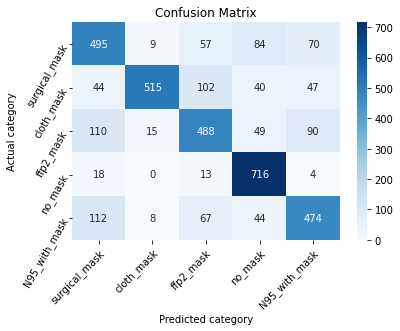

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.59      0.54      0.56       321
           1       0.52      0.79      0.63       206
           2       0.57      0.58      0.58       328
           3       0.84      0.61      0.70       441
           4       0.56      0.62      0.59       278

    accuracy                           0.61      1574
   macro avg       0.61      0.63      0.61      1574
weighted avg       0.64      0.61      0.62      1574

Testing Confusion Matrix: 


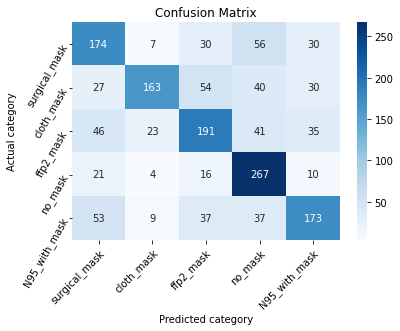

Predicting the labels from sample images:




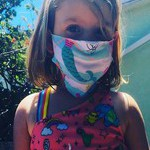

cloth_mask




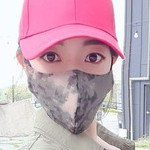

no_mask




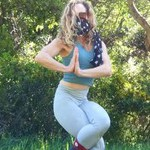

surgical_mask


In [636]:
FaceMaskDetection()